In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
#from telemetry_module import *
from copy import deepcopy
import pickle
import matplotlib as mpl
from scipy import interpolate
import time
from scipy.special import expit
from scipy.stats import gaussian_kde
from statsmodels.graphics import tsaplots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
#import geopandas as gpd
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib import ticker as mtick

In [3]:
from scipy.special import logit, expit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge, Lasso
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, LassoLarsIC

In [4]:
#from bayesfilt.telemetry.utils import *
from bayesfilt.filters.utils import get_covariance_ellipse
#from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *
from csg_resample_ks import *
data_dir = os.path.join(CSG_DIR, 'raw_data')

In [5]:
fpath = os.path.join(TELEMETRY_DIR, 'csg_ge_vr.prq_tracks_ca_annotated2')
df = pd.read_parquet(fpath)

In [8]:
df.columns.to_list()

['AccelerationVer',
 'AccelerationX',
 'AccelerationX_var',
 'AccelerationY',
 'AccelerationY_var',
 'AccelerationZ_var',
 'AccnHorRadial',
 'AccnHorTangential',
 'Age',
 'Altitude',
 'AltitudeAgl',
 'Altitude_var',
 'AnimalID',
 'BoundaryLayerHeight',
 'FalseFix',
 'GroundAspect',
 'GroundElevation',
 'GroundElevationD100',
 'GroundElevationD1000',
 'GroundElevationD100L15',
 'GroundElevationD100L30',
 'GroundElevationD100L60',
 'GroundElevationD100R15',
 'GroundElevationD100R30',
 'GroundElevationD100R60',
 'GroundElevationD120',
 'GroundElevationD1200',
 'GroundElevationD120L15',
 'GroundElevationD120L30',
 'GroundElevationD120L60',
 'GroundElevationD120R15',
 'GroundElevationD120R30',
 'GroundElevationD120R60',
 'GroundElevationD1600',
 'GroundElevationD200',
 'GroundElevationD2000',
 'GroundElevationD200L15',
 'GroundElevationD200L30',
 'GroundElevationD200L60',
 'GroundElevationD200R15',
 'GroundElevationD200R30',
 'GroundElevationD200R60',
 'GroundElevationD2400',
 'GroundElevat

In [16]:
df['HeadingRateFd'] = df['Heading'].diff().bfill().ffill()
df[['Heading','HeadingRate','HeadingRateFd']].iloc[1100:1100+17]

,Heading,HeadingRate,HeadingRateFd
1100,11.455965,21.925074,-13.663820
1101,-11.447768,17.121235,-22.903732
1102,-28.383259,5.856244,-16.935490
1103,-44.045235,-3.004704,-15.661976
1104,-39.639816,-9.987441,4.405418
1105,-28.383139,-16.068874,11.256678
1106,-13.341942,-18.675863,15.041197
1107,-1.022789,-15.862973,12.319153
1108,18.429523,-10.835373,19.452312
1109,27.065983,-6.288421,8.636459


<AxesSubplot: >

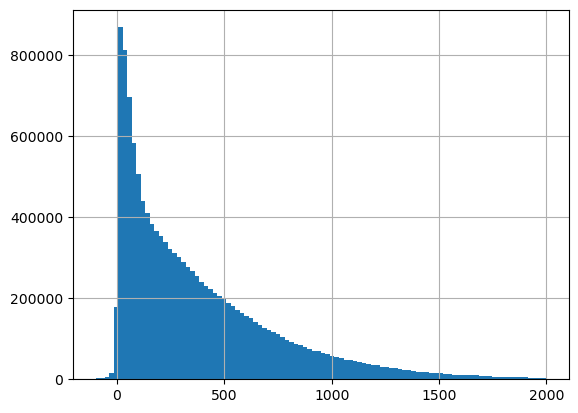

In [14]:
df.Altitude.subtract(df.GroundElevation).hist(bins=100, range=(-100,2000))

In [ ]:
%%time
df = get_annotated_telemetry_df()
#dfshort = get_dfshort(df)

In [ ]:
df.GroundSlope.hist(bins=100)

In [ ]:
dfshort = get_dfshort(df)

In [ ]:
#df['HeadingRateFdSmooth'] = df['HeadingRateFd'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['HeadingRateSmooth'] = df['HeadingRate'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmooth'] = df['AccelerationHor'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['AccnHorSmoothAbs'] = df['AccnHorSmooth'].abs()

In [ ]:
df[['Heading','HeadingRate','HeadingRateSmooth', 'HeadingRateFd', 'HeadingRateFdSmooth']].iloc[112000:112020]

## Tailwind and crosswind

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'VelocityHorRel'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.65)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.35)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0., handlelength=1.5, handletextpad=0.5, fancybox=True)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Rel. horizontal velocity, $v_h$-$w_t$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
save_paper_figure(fig, name=f'fig_wind_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'VelocityVer'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=3, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)
ax.legend(borderaxespad=0., handlelength=1.5, handletextpad=0.5, fancybox=True)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_wind_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'HeadingRate'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_wind_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'AccnHorSmooth'
xnames = {
    'WindSupport80m': r'Tailwind, $w_t$',
    'WindLateral80m': r'Crosswind, $w_c$'
}
for i, (xname, xlbl) in enumerate(xnames.items()):
    xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.5)
    ax.plot(xdata, ydata, '-r', color=clrs[i],linewidth=2., alpha=0.75, label=xlbl)
    xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.55)
    xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=5, qq=0.44)
    cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[i], ec=None)

ax.legend(borderaxespad=0.)
ax.set_xlabel(r'Wind speed [m/s]')
ax.set_ylabel(r'Rel. horizontal velocity, $v_h$-$w_t$ [m/s]')
ax.grid(True)
ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_wind_{yname}')

## Agl

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'VelocityVer'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_agl_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'AccelerationVer'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.65, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.35, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_agl_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'VelocityHor'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
save_paper_figure(fig, name=f'fig_agl_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'AccnHorTangential'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.65, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.35, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
save_paper_figure(fig, name=f'fig_agl_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'AccelerationHor'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
save_paper_figure(fig, name=f'fig_agl_{yname}')

In [ ]:
fig, ax = plt.subplots()
idf = dfshort
yname = 'HeadingRate'
xname = 'AltitudeAgl'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.5, quant=0.99)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.55, quant=0.99)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=7, qq=0.45, quant=0.99)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Altitude AGL, $h$ [m]')
ax.set_ylabel(r'Heading rate, $\omega$ [m/s]')
ax.grid(True)
ax.set_xlim([0,200])
save_paper_figure(fig, name=f'fig_agl_{yname}')

## cross relations

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityVer'
xname = 'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([5,25])
ax.set_ylim([-1.2,0.6])
ax.set_yticks([-1.2, -0.8, -0.4, 0, 0.4])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'AccelerationVer'
xname = 'AccnHorTangential'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
#ax.set_xlim([5,25])
#ax.set_ylim([-1.2,0.6])
#ax.set_yticks([-1.2, -0.8, -0.4, 0, 0.4])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityHor'
xname = 'VelocityVer' 
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.set_xlabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-3,2])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'VelocityVer'
xname = 'HeadingRate'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_ylabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-15,15])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'HeadingRate'
xname = 'VelocityVer' 
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_xlabel(r'Vertical velocity, $v_z$ [m/s]')
ax.grid(True)
ax.set_xlim([-3,2])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname = 'HeadingRate'
xname =  'VelocityHor'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_ylabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_xlabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([5,25])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

In [ ]:
fig, ax = plt.subplots()
qval = 0.99
nval = 5
idf = dfshort
yname =  'VelocityHor' 
xname = 'HeadingRate'
xdata, ydata, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.5, quant=qval)
xdata, ydata_upp, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.65, quant=qval)
xdata, ydata_low, ystd = get_xy_data(idf, xname, yname, nn=nval, qq=0.35, quant=qval)
ax.plot(xdata, ydata, '-r', color=clrs[0],linewidth=2., alpha=0.75)
cb = ax.fill_between(xdata, ydata_low, ydata_upp, alpha=0.1, color=clrs[0], ec=None)
ax.set_xlabel(r'Heading rate, $\omega$ [deg/s]')
ax.set_ylabel(r'Horizontal velocity, $v_h$ [m/s]')
ax.grid(True)
ax.set_xlim([-15,15])
# ax.set_ylim([-0.5,0.5])
save_paper_figure(fig, name=f'fig_{xname}_{yname}')

## time lagged

In [ ]:
variables

In [ ]:
tlags = time_lags
corr_dict = {}
for yname in variables['Pred'] :
    corr_dict[yname] = []
    for ilag in tlags:
        xname = f'{yname}Lag{ilag}'
        icorr = dfshort[xname].corr(dfshort[yname])
        corr_dict[yname].append(icorr)

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot([0]+tlags, [1]+corr_dict['VelocityHor'], '-r', color=clrs[0], label='Horizontal velocity')
#ax.plot([0]+tlags, [1]+corr_dict['VelocityVer'], '-r', color=clrs[1], label='Vertical velocity')
ax.plot([0]+tlags, [1]+corr_dict['AccnHorSmooth'], '-r', color=clrs[8], label='Hor accn smooth')
ax.plot([0]+tlags, [1]+corr_dict['AccelerationHor'], '-r', color=clrs[1], label='Hor accn')
ax.plot([0]+tlags, [1]+corr_dict['AccelerationVer'], '-r', color=clrs[4], label='Vertical accn')
#ax.plot([0]+tlags, [1]+corr_dict['AccelerationVerB'], '-r', color=clrs[0], label='Vertical accnB')
ax.plot([0]+tlags, [1]+corr_dict['HeadingRate'], '-r', color=clrs[2], label='Heading rate')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateFd'], '-r', color=clrs[3], label='Heading rate fd')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateSmooth'], '-r', color=clrs[5], label='Heading rate smooth')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateFdSmooth'], '-r', color=clrs[6], label='Heading rate fd smooth')
ax.legend(borderaxespad=0., ncol=1, loc=1)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
#ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
variables['Pred']

In [ ]:
np.linspace(0,100,20)

In [ ]:
[ix for ix in df.columns if 'Accn' in ix]